# 0. 필요 라이브러리 import

In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import random
import tqdm
from tqdm.auto import trange
import time
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1. Data 준비

## 1-1. Custom Dataloader 구현

In [2]:
class CustomCIFAR100Loader(Dataset):
    # ====== 초기화
    def __init__(self, root_dir, meta_file, train=True, transform=None):
        self.root_dir = root_dir  # 데이터셋 경로 지정
        self.transform = transform  # 데이터에 적용할 변환

        # 메타 데이터 파일에서 클래스 이름 로드
        with open(meta_file, 'rb') as f:
            meta_dict = pickle.load(f, encoding='bytes')
        self.category = [x.decode('utf-8') for x in meta_dict[b'fine_label_names']]

        # 데이터셋 파일 선택 및 데이터 불러오기
        file_path = os.path.join(self.root_dir, 'train' if train else 'test')
        with open(file_path, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')

        self.data = data_dict[b'data']
        self.labels = np.array(data_dict[b'fine_labels'])

        # (이미지 개수, 3, 32, 32) 형태로 변환
        self.data = self.data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)


    # ====== 데이터 길이 반환
    def __len__(self):
        return len(self.data)


    # ====== 하나의 data를 반환
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]  # label 번호
        category = self.category[label]  # label에 해당하는 직접적인 class name

        if self.transform:
            image = self.transform(Image.fromarray(image))
        return image, label

## 1-2. Dataset 다운로드 및 Dataloader 설정

In [3]:
# ===== 데이터셋을 위한 별도의 디렉토리 생성
os.makedirs('/content/dataset')
os.chdir('/content/dataset')


# ===== CIFAR100 데이터셋 준비
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz && \
tar -xzvf 'cifar-100-python.tar.gz'

# 데이터셋 경로와 메타 파일 경로 설정
root_dir = './cifar-100-python'
meta_file = './cifar-100-python/meta'


# ===== 데이터에 적용할 변환 설정
transform = transforms.Compose([
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
])


# ===== 데이터셋 생성 (Only train data)
dataset = CustomCIFAR100Loader(root_dir=root_dir, meta_file=meta_file, train=True, transform=transform)

# 가져온 5만 장의 train data를 4:1로 분할
train_data, val_data = random_split(dataset, [40000, 10000])


# ===== 각각 dataloader 설정
# 이때 train은 데이터를 무작위로 섞어 일반화 성능을 높일 수 있도록 shuffle=True로 설정
# validation은 검증의 일관성을 유지할 수 있도록 shuffle=False로 설정
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

--2024-02-29 14:23:37--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  8.67MB/s    in 2m 7s   

2024-02-29 14:25:46 (1.27 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## 1-3. Data Visualization

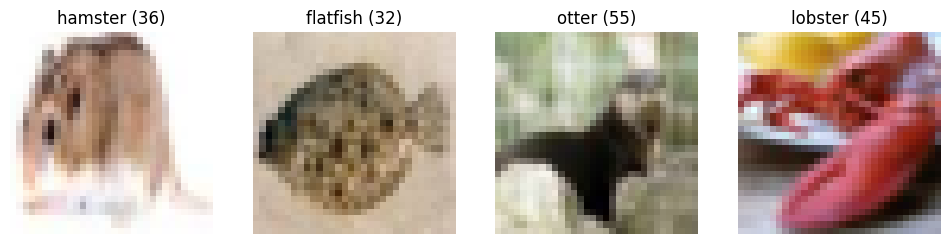

In [4]:
# ===== train dataset의 첫 번째 배치에서 무작위로 이미지 4개 선택
images, labels = next(iter(train_loader))
all_idx = list(range(len(images)))  # 가능한 모든 인덱스 (batch size에 따라 달라짐)
random_idx = random.sample(all_idx, 4)  # 4개의 인덱스를 무작위로 선택

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i, idx in enumerate(random_idx):
    image = images[idx] / 2 + 0.5  # 정규화된 pixel을 원래 범위로 되돌리기
    image = image.numpy()

    # pytorch image format인 CHW를 matplotlib에서 사용할 수 있는 HWC format으로 변환
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title('{} ({})'.format(dataset.category[labels[idx]], labels[idx]))
    axs[i].axis('off')  # 축 없애기


# ===== class label과 함께 이미지 출력
plt.show()

# 2. CNN 모델 구현: ResNet-50

## 2-1. Basic Module
> 자주 사용하게 될 conv1와 conv3 블럭을 별도로 먼저 구현하고, 이후 이를 포함한 basic module을 생성

### 2-1-1. Conv 1\*1 layer와 Conv 3\*3 layer 구현

In [5]:
def conv_1x1(in_channels, out_channels, stride = 1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 1,
        stride = stride,
        bias = False
    )


def conv_3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = stride,
        padding = 1,
        bias = False
    )

### 2-1-2. Basic module 구현

In [6]:
class BasicBlock(nn.Module):
    # 출력 채널 수에 대한 확장 비율
    # BasicBlock의 입력 채널 수와 출력 채널 수는 동일하게 유지되어야 하므로 1
    expansion = 1


    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()

        # 첫 번째 Conv layer (3x3) + Batch Normalization
        self.conv1 = conv_3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 두 번째 Conv layer (3x3) + Batch Normalization
        self.conv2 = conv_3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 입출력 차원 맞추기
        self.stride = stride


    def forward(self, x):
        identity = x  # 잔차

        # 첫 번째 Conv, Batch Norm, ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 두 번째 Conv, Batch Norm
        out = self.conv2(out)
        out = self.bn2(out)

        # Downsampling 정의된 경우 잔차에 적용
        if self.downsample is not None:
            identity = self.downsample(x)

        # Residual connection 및 activation function 적용
        out += identity
        out = self.relu(out)

        return out

## 2-2. Bottleneck Module

In [7]:
class Bottleneck(nn.Module):
    # 출력 채널 수에 대한 확장 비율
    # Bottleneck에서는 출력 채널 수가 입력 채널 수의 4배가 됨
    expansion = 4


    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(Bottleneck, self).__init__()

        # 첫 번째 Conv layer (1x1) + Batch Normalization
        self.conv1 = conv_1x1(in_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 두 번째 Conv layer (3x3) + Batch Normalization
        # 여기서 stride를 통한 다운샘플링 적용 가능
        self.conv2 = conv_3x3(out_channels, out_channels, stride)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 세 번째 Conv layer (1x1) + Batch Normalization: 출력 채널 수 확장
        self.conv3 = conv_1x1(out_channels, out_channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 입출력 차원 맞추기
        self.stride = stride


    def forward(self, x):
        identity = x  # 잔차

        # 첫 번째 Conv, Batch Norm, ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 두 번째 Conv, Batch Norm, ReLU
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 세 번째 Conv, Batch Norm
        out = self.conv3(out)
        out = self.bn3(out)

        # 다운샘플링이 정의된 경우, 잔차에 적용
        if self.downsample is not None:
            identity = self.downsample(x)

        # 잔차 연결 및 최종 ReLU
        out += identity
        out = self.relu(out)

        return out

## 2-3. ResNet

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        # 초기 layer 및 activation function, pooling 설정
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)


        # ResNet layer 생성
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 가중치 초기화 (별도 함수 구현)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)



    def _make_layer(self, block, out_channels, blocks, stride = 1):
        downsample = None

        # stride가 1이 아니거나 입출력 채널 사이즈가 다를 경우 다운샘플링
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv_1x1(self.in_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        # 초기 layer 통과
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResNet layer 통과
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # 최종 layer 통과
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# 3. Train, Validate, Test and Experiment

In [9]:
def train(model, data_loader, optimizer, criterion):
    # 모델을 학습 모드로 설정
    model.train()

    # 초기화
    correct = 0
    total = 0
    train_loss = 0.0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for inputs, labels in data_loader:
        # GPU로 데이터 이동
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # optimizer 초기화

        # output, loss 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 계산 및 최적화
        loss.backward()
        optimizer.step()

        # train loss와 acc 계산
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 평균 train loss 및 acc 계산
    train_loss /= len(data_loader)
    train_acc = 100 * correct / total

    return model, train_loss, train_acc


def validate(model, data_loader, criterion):
    # 모델을 평가 모드로 전환
    model.eval()

    # 초기화
    val_loss = 0
    correct = 0
    total = 0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # output loss 계산
            outputs = model(images)
            loss = criterion(outputs, labels)

            # val loss 및 acc 계산
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 val loss 및 acc 계산
    val_loss /= len(data_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc


In [10]:
def experiment(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ResNet-18 모델 초기화
    model = ResNet(Bottleneck, [2, 2, 2, 2], num_classes = 1000).to(device)

    # loss는 CrossEntropy
    criterion = nn.CrossEntropyLoss()

    # optimizer 설정
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    # 학습률 스케줄러 지정
    scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0.001)

    # 결과 저장 리스트 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # epoch 만큼 반복
    for epoch in range(args.epoch):
        start_time = time.time()  # 시작 시간

        model, train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        scheduler.step()

        end_time = time.time()  # 끝 시간 기록 후 계산

        # 결과를 각각 생성해둔 리스트에 추가
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch}, Acc(train/val): {train_acc:.2f}/{val_acc:.2f}, Loss(train/val): {train_loss:.2f}/{val_loss:.2f}. Took {end_time-start_time:.2f} sec')


    # 계산된 결과 저장 및 반환
    result = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

    # 최종 모델 가중치 저장
    weight_save_path = f"saved_weights_final_epoch_{args.epoch}.pth"  # 최종 파일명 생성
    torch.save(model.state_dict(), weight_save_path)

    return vars(args), result

In [11]:
class Args:
    lr = 0.1  # learning rate
    l2 = 1e-4  # weight decay
    epoch = 30
    train_batch_size = 512
    test_batch_size = 1024
    optim = 'SGD'
    exp_name = 'exp1'


args = Args()

In [20]:
# ===== 실험 설정 및 결과 저장
def save_exp_result(setting, result):
    # 실험 이름 설정
    exp_name = args.exp_name
    # 해시 함수를 통해 파일 이름을 생성
    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)

    # 결과에 실험 설정을 추가 후 저장
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


# 저장된 실험 이름에 해당하는 실험 결과 로드하여 DataFrame으로 반환
def load_exp_result(exp_name):
    # 결과 파일이 저장된 디렉토리 목록 가져오기
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]

    # 지정된 실험 이름을 포함하는 파일의 결과를 리스트에 저장
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)

    # 저장된 결과 리스트를 DataFrame으로 변환하여 반환
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [13]:
# 실험 설정 및 결과 저장
os.makedirs('./results')
setting, result = experiment(args)
save_exp_result(setting, result)

Epoch 0, Acc(train/val): 1.88/2.69, Loss(train/val): 5.10/9.04. Took 139.62 sec
Epoch 1, Acc(train/val): 2.87/4.25, Loss(train/val): 4.52/4.83. Took 137.90 sec
Epoch 2, Acc(train/val): 4.22/6.15, Loss(train/val): 4.38/5.22. Took 136.90 sec
Epoch 3, Acc(train/val): 5.18/7.52, Loss(train/val): 4.31/4.39. Took 137.15 sec
Epoch 4, Acc(train/val): 5.50/7.32, Loss(train/val): 4.26/4.14. Took 137.18 sec
Epoch 5, Acc(train/val): 6.86/9.75, Loss(train/val): 4.16/4.11. Took 137.41 sec
Epoch 6, Acc(train/val): 8.34/12.85, Loss(train/val): 4.04/3.83. Took 137.51 sec
Epoch 7, Acc(train/val): 9.96/12.99, Loss(train/val): 3.95/3.89. Took 137.63 sec
Epoch 8, Acc(train/val): 11.49/14.88, Loss(train/val): 3.84/3.63. Took 139.40 sec
Epoch 9, Acc(train/val): 12.94/16.46, Loss(train/val): 3.75/3.66. Took 136.58 sec
Epoch 10, Acc(train/val): 14.58/18.61, Loss(train/val): 3.65/3.45. Took 137.19 sec
Epoch 11, Acc(train/val): 16.00/20.96, Loss(train/val): 3.57/3.33. Took 137.71 sec
Epoch 12, Acc(train/val): 17

KeyError: 'exp_name'

In [21]:
save_exp_result(setting, result)


Final Training Accuracy: 46.3025
Final Validation Accuracy: 37.66
